## Load the data and ignore the warnings

In [4]:
import sys
import pandas as pd
import csv

# Increase CSV field size limit
csv.field_size_limit(sys.maxsize)

# Reload with safe options
df = pd.read_csv('combined_raw_dataset.csv', engine='python', on_bad_lines='skip')

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118965 entries, 0 to 118964
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Message        118965 non-null  object
 1   label          118965 non-null  int64 
 2   Clean_Message  118929 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


,Message,label,Clean_Message
0,\n\nStart Date: 10/13/01; HourAhead hour: 22; ...,0,start date: 10/13/01 hourahead hour: 22 ancill...
1,---------------------- Forwarded by Vince J Ka...,0,forwarded vince kaminski/hou/ect 03/27/2000 20...
2,\n [IMAGE] Webcast June 14th @ 2:00...,0,image webcast june 14th @ 2:00pm edt click reg...
3,\n\n -----Original Message-----\nFrom: =09Dupo...,0,original message from: 09dupont anita 20 sent:...
4,"Jeff--please change my name to ""mike d. smith""...",0,jeffplease change name mike smith thanks forwa...


In [6]:
df['label'].value_counts(dropna=False)

,count
label,
0,109410
1,9555


In [7]:
# Show labels that are not exactly 0 or 1
df[~df['label'].astype(str).isin(['0', '1'])]['label'].unique()

array([], dtype=int64)

In [8]:
# Add 'source' column for visualizations
df['source'] = df['label'].apply(lambda x: 'phish' if x == 1 else 'benign')
df['source'].value_counts()

,count
source,
benign,109410
phish,9555


## Feature 1: 'has_html'

In [9]:
import re

def contains_html(text):
    if pd.isnull(text):
        return 0
    return 1 if re.search(r'<[^>]+>', text) else 0


df['has_html'] = df['Message'].apply(contains_html)
df['has_html'].value_counts()

,count
has_html,
0,99020
1,19945


## Feature 2: link count

In [10]:
# Function to count links in a message
def count_links(text):
    if pd.isnull(text):
        return 0
    return len(re.findall(r'http[s]?://\S+|www\.\S+', text))

# Apply to 'Message'
df['link_count'] = df['Message'].apply(count_links)

# Quick stats
df['link_count'].describe()


,link_count
count,118965.000000
mean,0.704602
std,5.314994
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,539.000000


### Insights:
1. Most emails (≥75%) have no links.

2. But a few have a lot, which brings the average up.

3. Phishing emails are likely hiding in those outliers.

In [11]:
df.groupby('has_html')['link_count'].mean()

,link_count
has_html,
0,0.405888
1,2.187616


### Insight:
HTML emails are ~5x more likely to contain links than plain-text ones.

## Feature 3: shannon_entropy

###  What is it?

**Shannon entropy** measures the **randomness** or **information density** in a text. It’s calculated based on the distribution of characters.

---

###  Why is it useful for phishing?

Phishing and spam messages often:

* Contain **obfuscated text** (random strings, gibberish)
* Hide malicious intent using **encoded text** (e.g., base64 or hex payloads)
* Have **higher entropy** than normal human-written messages

Benign messages, like regular reports or human emails, tend to have **lower entropy** (repetitive, structured).

---

###  How is it calculated?

The formula is:

$$
H = -\sum_{i} p_i \log_2 p_i
$$

Where:

* $p_i$ is the probability of character $i$
* We sum over all unique characters in the string



In [12]:
import math
from collections import Counter

def shannon_entropy(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text) == 0:
        return 0
    counts = Counter(text)
    total = len(text)
    entropy = -sum((count/total) * math.log2(count/total) for count in counts.values())
    return entropy

df['entropy'] = df['Clean_Message'].apply(shannon_entropy)
# Check basic stats
df['entropy'].describe()


,entropy
count,118965.000000
mean,4.299071
std,0.285916
min,0.000000
25%,4.203838
50%,4.346662
75%,4.458353
max,5.194621


In [13]:
df.groupby('source')['entropy'].mean()

,entropy
source,
benign,4.293172
phish,4.366617


### Insight:
High entropy → more randomness → possibly phishing.


## Feature 4: Urgency Keyword Score

###  What is it?

A numeric score that counts how many **urgency-related words** appear in the email.

Example keywords:

* `urgent`, `immediately`, `action required`, `verify`, `now`, `alert`, `suspend`, `account`, `deadline`, etc.

---

###  Why is it useful?

Phishing emails often use emotional language to **trick users into acting fast**. Urgency is a common social engineering tactic.

 Typical subject lines:

* “**URGENT**: Account access suspended”
* “**ACTION REQUIRED**: Verify your information now”
* “You have **24 hours** to respond”

Benign emails usually don’t use this tone.

---

###  How does it work?

We’ll:

1. Define a list of urgency-related keywords (all lowercase).
2. Count how many of them appear in each email's **Clean\_Message**.
3. Store that count as the `urgency_score`.



In [14]:
# List of urgency-related words
urgency_keywords = [
    'urgent', 'immediately', 'action required', 'verify', 'now', 'alert', 'suspend',
    'confirm', 'update', 'security', 'click', 'login', 'respond', 'access', 'deadline'
]

def count_urgency(text):
    if pd.isnull(text) or not isinstance(text, str):
        return 0
    text = text.lower()
    return sum(text.count(word) for word in urgency_keywords)

df['urgency_score'] = df['Clean_Message'].apply(count_urgency)
df['urgency_score'].describe()

,urgency_score
count,118965.000000
mean,1.635069
std,4.270660
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,224.000000


In [15]:
df.groupby('source')['urgency_score'].mean()

,urgency_score
source,
benign,1.649922
phish,1.464992


## Feature 5: emotion density

In [16]:
# List of emotional words
emotion_words = [
    'fear', 'panic', 'urgent', 'immediately', 'risk', 'danger', 'suspend', 'failure',
    'reward', 'win', 'free', 'gift', 'lucky', 'congratulations', 'sorry', 'help',
    'violation', 'error', 'unauthorized', 'alert', 'notice', 'warning', 'problem',
    'lost', 'important', 'verify', 'secure', 'threat'
]

def emotion_density(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    text = text.lower()
    words = text.split()
    if len(words) == 0:
        return 0
    count = sum(word in emotion_words for word in words)
    return count / len(words)

df['emotion_density'] = df['Clean_Message'].apply(emotion_density)
df['emotion_density'].describe()

,emotion_density
count,118965.000000
mean,0.005390
std,0.017042
min,0.000000
25%,0.000000
50%,0.000000
75%,0.005464
max,1.000000


In [17]:
df.groupby('source')['emotion_density'].mean()

,emotion_density
source,
benign,0.004937
phish,0.010573


### Insight:
Phishing emails often use emotionally manipulative language.

## Feature 6:character/word counts

In [18]:
# Character count (includes punctuation, spacing)
df['char_count'] = df['Clean_Message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Word count (tokens separated by space)
df['word_count'] = df['Clean_Message'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

df[['char_count', 'word_count']].describe()

,char_count,word_count
count,1.189650e+05,118965.000000
mean,1.440067e+03,200.138814
std,7.141991e+03,666.271838
min,0.000000e+00,0.000000
25%,2.300000e+02,34.000000
50%,5.840000e+02,85.000000
75%,1.388000e+03,198.000000
max,1.689319e+06,46275.000000


## Recap:
| Feature           | Type             | Description                            |
| ----------------- | ---------------- | -------------------------------------- |
| `has_html`        | Binary           | Whether the message contains HTML tags |
| `link_count`      | Integer          | Number of links in the message         |
| `entropy`         | Float            | Shannon entropy of the cleaned message |
| `urgency_score`   | Integer          | Count of urgency-related keywords      |
| `emotion_density` | Float            | Emotion words per word in message      |
| `char_count`      | Integer          | Character count of the cleaned message |
| `word_count`      | Integer          | Word count of the cleaned message      |
| `label`           | 0/1              | 1 = phishing, 0 = benign               |
| `source`          | 'phish'/'benign' | For easier EDA/visualization           |



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Distribution of Features by Class

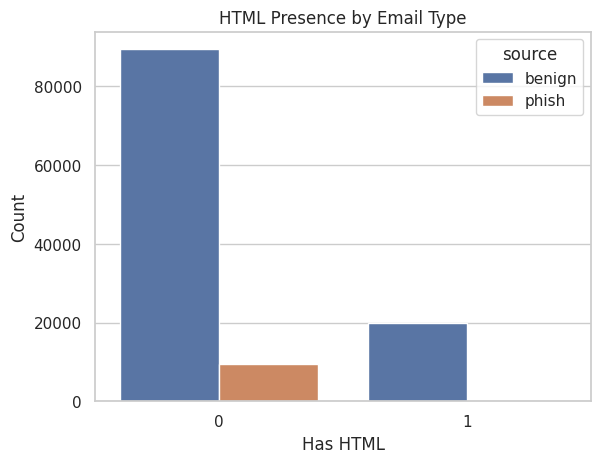

In [20]:
sns.countplot(x='has_html', hue='source', data=df)
plt.title("HTML Presence by Email Type")
plt.xlabel("Has HTML")
plt.ylabel("Count")
plt.show()

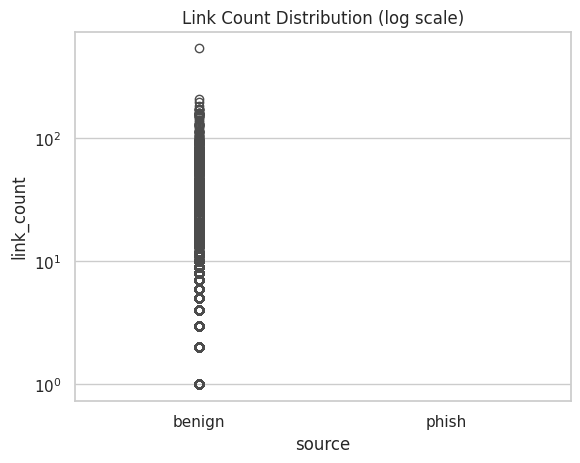

In [21]:
sns.boxplot(x='source', y='link_count', data=df)
plt.yscale('log')
plt.title("Link Count Distribution (log scale)")
plt.show()

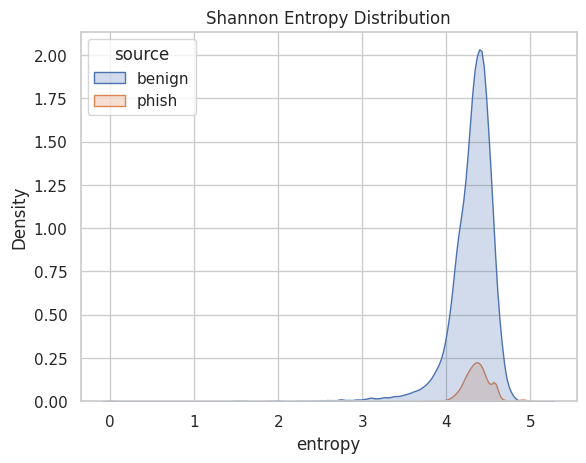

In [22]:
sns.kdeplot(data=df, x='entropy', hue='source', fill=True)
plt.title("Shannon Entropy Distribution")
plt.show()

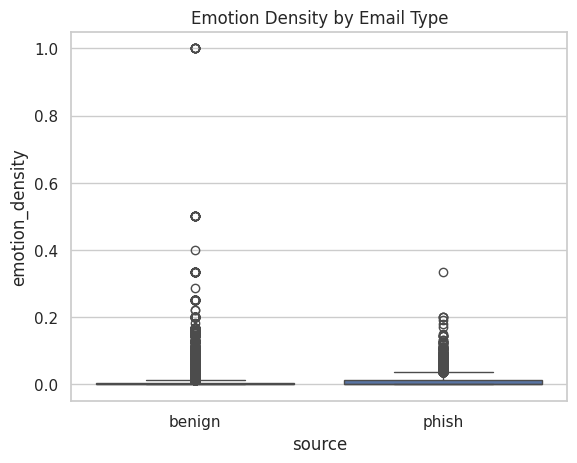

In [23]:
sns.boxplot(x='source', y='emotion_density', data=df)
plt.title("Emotion Density by Email Type")
plt.show()

## Feature Correlation Heatmap

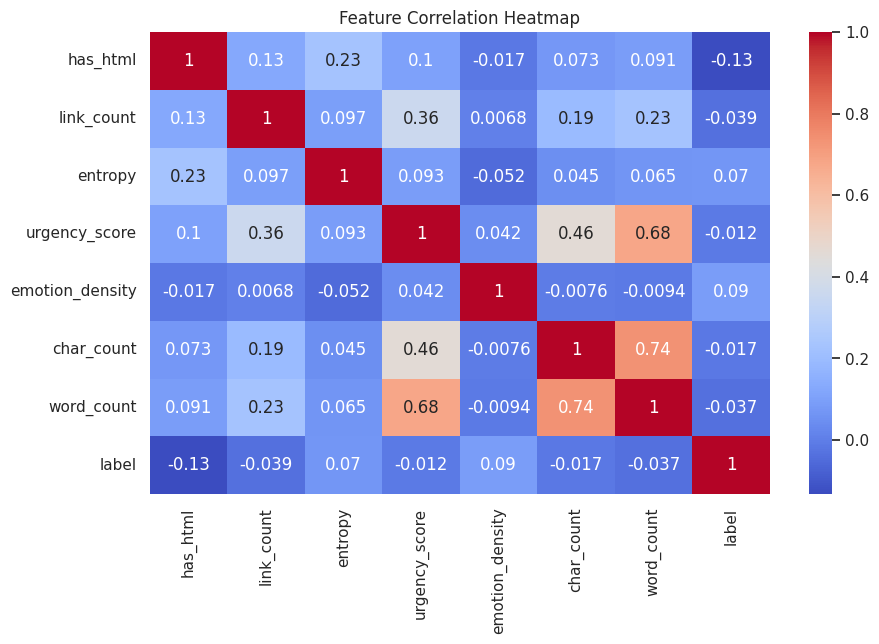

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['has_html', 'link_count', 'entropy', 'urgency_score', 'emotion_density', 'char_count', 'word_count', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Most Common Words

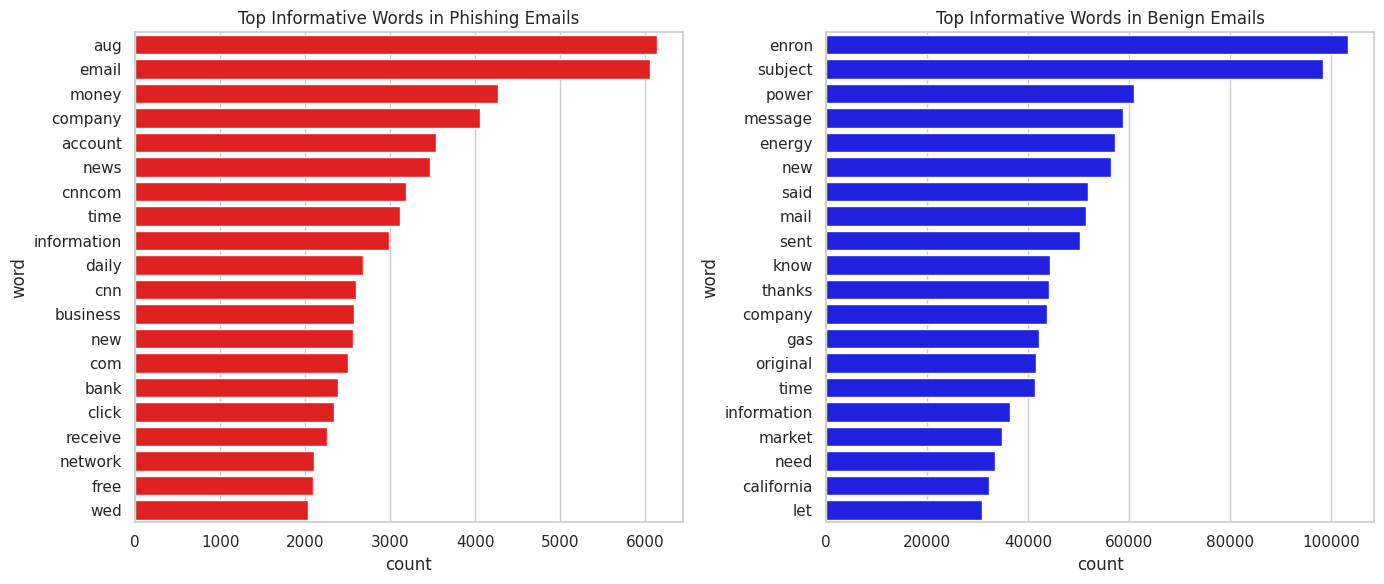

In [29]:
import string
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Function to clean, tokenize, and count words
def get_top_clean_words(texts, n=20):
    stop_words = set(ENGLISH_STOP_WORDS)
    all_text = ' '.join(texts.dropna().astype(str)).lower()
    # Remove punctuation and digits
    all_text = all_text.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = all_text.split()
    # Filter out stopwords and meaningless tokens
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    return Counter(filtered_words).most_common(n)

# 2. Extract top words per class
top_phish_clean = get_top_clean_words(df[df['label'] == 1]['Clean_Message'])
top_benign_clean = get_top_clean_words(df[df['label'] == 0]['Clean_Message'])

# 3. Convert to DataFrame for plotting
phish_df_clean = pd.DataFrame(top_phish_clean, columns=['word', 'count'])
benign_df_clean = pd.DataFrame(top_benign_clean, columns=['word', 'count'])

# 4. Plot bar charts
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=phish_df_clean, x='count', y='word', color='red')
plt.title("Top Informative Words in Phishing Emails")

plt.subplot(1, 2, 2)
sns.barplot(data=benign_df_clean, x='count', y='word', color='blue')
plt.title("Top Informative Words in Benign Emails")

plt.tight_layout()
plt.show()

In [25]:
pip install wordcloud


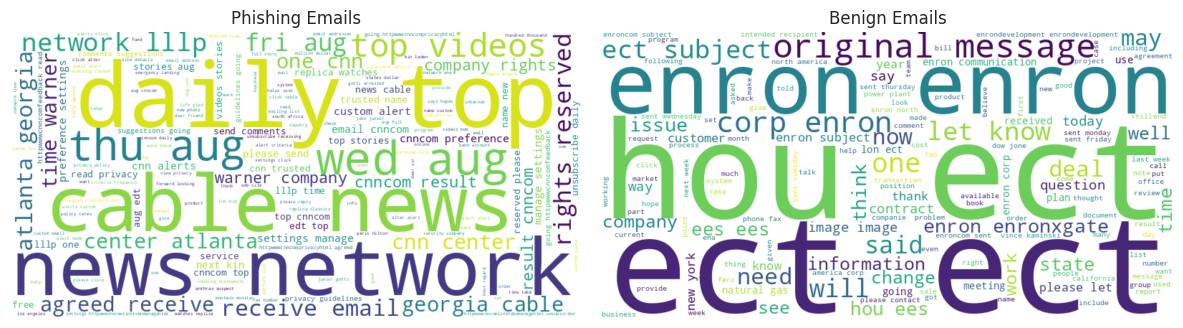

In [26]:
from wordcloud import WordCloud
# Join all words into a single string
phish_text = ' '.join(df[df['label'] == 1]['Clean_Message'].dropna().astype(str))
benign_text = ' '.join(df[df['label'] == 0]['Clean_Message'].dropna().astype(str))

# Generate word clouds
phish_wc = WordCloud(width=800, height=400, background_color='white').generate(phish_text)
benign_wc = WordCloud(width=800, height=400, background_color='white').generate(benign_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(phish_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Emails")

plt.subplot(1, 2, 2)
plt.imshow(benign_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Benign Emails")

plt.tight_layout()
plt.show()


In [30]:
# save
df.to_csv("combined_featured_dataset.csv", index=False)
